In [1]:
#| default_exp components

%load_ext autoreload
%autoreload 2


# Transformers components to be assembled in a model

Work in progress

References:
- https://web.stanford.edu/class/cs224n/slides/cs224n-2022-lecture09-transformers.pdf

In [2]:
#| export
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from dataclasses import dataclass
import math
import random

#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device('cpu')
g = torch.Generator().manual_seed(42)

## Embeddings

- Token embeddings, using torch embedding lookup
- Positional embedding, which can be fixed or learned.

In [3]:
#| export
class TokenEmbeddings(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int) -> None:
        super().__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim=embedding_dim)
        
    def forward(self, x):
        return self.embedding(x)

In [4]:
vocab_size = 6
embedding_dim = 50
emb = TokenEmbeddings(vocab_size, embedding_dim=embedding_dim)
emb.to(device)
x = torch.tensor([[0,1,2,1]], dtype=torch.long, device=device)
emb_x = emb(x)
assert emb_x.shape==(x.shape[0], x.shape[1], embedding_dim)

# test if we can compute grandient on module
emb_x.retain_grad()
target = torch.rand(x.shape[0], x.shape[1], embedding_dim).to(device)
loss = torch.norm(emb_x-target)
loss.backward()
loss.item(), emb_x.grad.shape

(14.323200225830078, torch.Size([1, 4, 50]))

### Positional Encoding

As each word in a sentence simultaneously flows through the Transformer’s encoder/decoder stack, The model itself doesn’t have any sense of position/order for each word. Consequently, there’s still the need for a way to incorporate the order of the words into our model.
So we give the model some sense of position of the token in the sequence. 

Either we give the position as an input to the model or the model learns it.

#### Non learned positional embeddings

##### Potential solutions:

The first idea that might come to mind is to assign a number to each time-step within the [0, 1] range in which 0 means the first word and 1 is the last time-step. One of the problems it will introduce is that you can’t figure out how many words are present within a specific range. In other words, time-step delta doesn’t have consistent meaning across different sentences.

Another idea is to assign a number to each time-step linearly. That is, the first word is given “1”, the second word is given “2”, and so on. The problem with this approach is that not only the values could get quite large, but also our model can face sentences longer than the ones in training.

Ideally, the following criteria should be satisfied:

- It should output a unique encoding for each time-step (word’s position in a sentence)
- Distance between any two time-steps should be consistent across sentences with different lengths.
- Our model should generalize to longer sentences without any efforts. Its values should be bounded.
- It must be deterministic.

##### Proposed solutions:

The initial solution that was proposed isn’t a single number. Instead, it’s a d-dimensional vector that contains information about a specific position in a sentence. This vector, if not learned, is not integrated in the model.

$\begin{align}
  \vec{p_t}^{(i)} = f(t)^{(i)} & := 
  \begin{cases}
      \sin({\omega_k} . t),  & \text{if}\  i = 2k \\
      \cos({\omega_k} . t),  & \text{if}\  i = 2k + 1
  \end{cases}
\end{align} $

where $\omega_k = \frac{1}{n^{2k / d}}$

where : 
- L: sequence length
- t: position of token in input sequence
- d: dimension of positon embedding (same as token embedding)
- P(t,j): position function to map a position t in sequence to index (t,i) in positional matrix
- n: user defined scalar (ex: 10'000)
- i: index on the position embedding
- k: floor division (partie entière) of i by 2, so i = 2k (i is even - pair) or i=2k+1 (i is odd - impair), because we add a sin/cos pair on every two embedding slot

The frequency of sinusoidal is decreasing with the vector dimension (as i grows)

So we got a vector with pairs of sin/cosines for each frequency.

$\vec{p_t} = \begin{bmatrix} 
\sin({\omega_1}.t)\\ 
\cos({\omega_1}.t)\\ 
\\
\sin({\omega_2}.t)\\ 
\cos({\omega_2}.t)\\ 
\\
\vdots\\ 
\\
\sin({\omega_{d/2}}.t)\\ 
\cos({\omega_{d/2}}.t) 
\end{bmatrix}_{d \times 1}$

It's like the encoding of numbers in binary format: 

$
\begin{align}
  0: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} & & 
  8: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} \\
  1: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} & & 
  9: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} \\ 
  2: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} & & 
  10: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} \\ 
  3: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} & & 
  11: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} \\ 
  4: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} & & 
  12: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} \\
  5: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} & & 
  13: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} \\
  6: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} & & 
  14: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} \\
  7: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} & & 
  15: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} \\
\end{align}$

where last bit is alternating on every number and previous on every 2 numbers, and so on. So instead of using bits (which would be a waste of space), we use continuous float variant with sinuosidal functions..

## References

- https://erdem.pl/2021/05/understanding-positional-encoding-in-transformers
- https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
- https://kikaben.com/transformers-positional-encoding/
- http://nlp.seas.harvard.edu/annotated-transformer/#positional-encoding
- https://towardsdatascience.com/master-positional-encoding-part-i-63c05d90a0c3



In [5]:
#| export

class PositionalEncoder(nn.Module):
    ''' Module to encode position in a transformer like model. 
    

    Args:
        max_seq_len (int): max length of sequence, aka L
        embedding_dim (int): dimension of embeddings in model, aka d
        dropout (float):  dropout rate. 0. for no dropout. 
        is_learned (bool): true if the position is learned through gradient descent or given (non differentiable) as defined in original paper Attention is all you need, https://arxiv.org/abs/1706.03762        
        n (int): user defined scalar set by default to 10000 as in paper        
    '''    
        
    def positional_encoding(self):
        pos = torch.arange(0,self.max_seq_len).repeat(self.embedding_dim, 1)
        i = torch.arange(0,self.embedding_dim)
        k = i // 2        
        wt = pos.T/(self.n**(2*k/self.embedding_dim))
        sin = torch.sin(wt)
        cos = torch.cos(wt)
        pe = torch.zeros((self.max_seq_len,self.embedding_dim))
        pe[:,0::2]= sin[:,0::2]
        pe[:,1::2]=cos[:,1::2]
        return pe

    def __init__(self, max_seq_len: int, embedding_dim: int, dropout: float = 0.,is_learned: bool = True, n:int=10000) -> None:
        super().__init__()
        self.max_seq_len = max_seq_len
        self.embedding_dim = embedding_dim
        self.is_learned = is_learned
        self.n = n
        self.dropout = nn.Dropout(p=dropout)
        if self.is_learned:            
            pos = torch.arange(0, self.max_seq_len, dtype=torch.long).unsqueeze(0) # shape (1, max_seq_len)
            self.register_buffer('pos', pos)
            self.pos_embedding = nn.Embedding(max_seq_len, embedding_dim)
        else:
            pos_encodings = self.positional_encoding().unsqueeze(0)
            pos_encodings.requires_grad_(False)
            # a buffer is a state in module which is not a parameter (learned)
            self.register_buffer('pos_encodings',pos_encodings)
            
    def forward(self, x):
        if self.is_learned:            
            x = x + self.pos_embedding(self.pos)
        else:
            x= x + self.pos_encodings
        return self.dropout(x)            
                        
 

In [6]:
# Check that we gradient computation works on learned positional encoder
seq_len = 20
embedding_dim = 50
l_pos_enc = PositionalEncoder(max_seq_len=seq_len, embedding_dim=embedding_dim, dropout=0.1, is_learned=True).to(device) 
x = torch.zeros(1, seq_len, embedding_dim, device=device)
pe = l_pos_enc.forward(x)
# test if we can compute grandient on module
pe.retain_grad()
target = torch.rand(*pe.shape).to(device)
print(target.shape, pe.shape)
loss = torch.norm(pe-target)
loss.retain_grad()
loss.backward()
loss.item(), pe.grad.shape, loss.grad

torch.Size([1, 20, 50]) torch.Size([1, 20, 50])


(37.544498443603516, torch.Size([1, 20, 50]), tensor(1.))

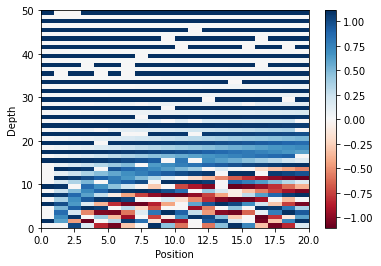

In [7]:
# non learned positional encoding
seq_len = 20
embedding_dim = 50
pos_enc = PositionalEncoder(max_seq_len=seq_len, embedding_dim=embedding_dim, dropout=0.1, is_learned=False) 
pos_enc.to(device)
pos_enc.positional_encoding()       
x = torch.zeros(1, seq_len, embedding_dim, device=device)
pe = pos_enc.forward(x)
np_pe = pe.cpu().detach().numpy()
plt.pcolormesh(np_pe[0].T, cmap='RdBu')
plt.xlabel('Position')
plt.ylabel('Depth')
plt.colorbar()
plt.show()



## Attention mechanisms

### attention function

In [8]:
#| export
def unidirectional_mask(seq_len:int):
    inverse_mask = torch.triu(torch.ones((1, seq_len,seq_len)), diagonal=1).type(torch.uint8)
    mask = (inverse_mask==0)
    return mask


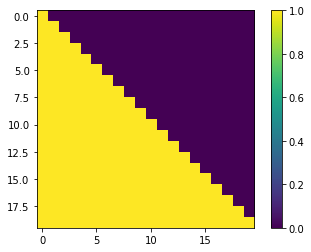

In [10]:
mask = unidirectional_mask(20)
plt.imshow(mask[0])
plt.colorbar()
plt.show()   


## Attention mechanism
Based on formal algorithm for transformers (https://arxiv.org/abs/2207.09238) where it can be used for different attention architectures like 
- encoder-decoder/seq-to-seq (very first transformer), 
- encoder-only (bert), 
- decoder-only (gpt-*, gopher). 

### Encoder-decoder architecture use 2 sequences as input
- context sequence of tokens (z), which is used to encode context as a vector per token with bidirectional attention
- primary sequence of tokens (x), which is used to decode both the encoded context and a masked primary sequence (tokens in primary sequence that precedes current). This is used to train a translator from FR to EN for instance. FR tokens are the context sequence and EN tokens are the primary sequence (target)
 
### Encoder only architecture use 1 primary sequence as input
Given a primary input sequence (x) with some tokens masked out, the goal is to recover the masked tokens. the goal is to learn a generally usefull representation of text. Uses a bidirectional attention

### Decoder only architecture use 1 primary sequence as input
Autoregressive language modelling where the goal is to predict the next token of a primary token sequence (x). Uses a unidirectional attention. 

In [ ]:
#| export
def attention(query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, 
              mask: torch.Tensor = None, dropout: torch.nn.Module = None, verbose: bool = False) -> tuple[torch.Tensor, torch.Tensor]:
    # is the size of atttention (=d//nb heads, where d is the size of attn model)
    d_k = query.size(-1)    
    #scores = (query @ key.transpose(-2,-1)) /(torch.sqrt(torch.tensor(d_k, requires_grad=False)))
    scores = (query @ key.transpose(-2,-1)) / math.sqrt(d_k)
    if mask is not None:
        # mask scores with -inf when mask is False. If we masked_fill(mask, -inf), it would mask when mask ==1 (is true). We want to mask when it's 0 (false).
        scores = scores.masked_fill(mask==0, float('-inf'))
    if verbose:
        print("scores, mask", mask is not None, scores)
    soft = F.softmax(scores, dim=-1)
    if verbose:
        print("soft, mask", mask is not None, soft)
    if dropout is not None:        
        soft = dropout(soft)        
    atn = soft @ value
    if verbose:
        print("atn, mask", mask is not None, atn)
    
    assert atn.shape == query.shape, f"atn shape {atn.shape} should be the same as input tensors key, query and value shapes. Query shape: {query.shape}"
    return atn, soft


In [ ]:
h = 5 #nb of heads
d_k = embedding_dim//h
batch_size=2
# shape is batch, h, seq_len, d_k
Q = torch.randn((batch_size, h, seq_len, d_k),generator=g, device=device, requires_grad=True)    
K = torch.randn((batch_size, h, seq_len, d_k),generator=g, device=device, requires_grad=True)    
V = torch.randn((batch_size, h, seq_len, d_k),generator=g, device=device, requires_grad=True)    
mask = unidirectional_mask(seq_len).to(device)
attn, attn_weight = attention(Q,K,V, mask=mask, dropout=torch.nn.Dropout(0.))
attn_no_mask, attn_weight_no_mask = attention(Q,K,V, dropout=torch.nn.Dropout(0.))

plt.imshow(attn[0][0].cpu().detach().numpy())
plt.colorbar()
plt.show()   

np_attn_weight = attn_weight.cpu()
np_sum = torch.sum(np_attn_weight, dim=1).cpu().detach().numpy()
plt.imshow(np_sum[0]) 
plt.colorbar()
plt.show()   


target = torch.rand(*attn.shape).to(device)
print(target.shape, pe.shape)
loss = torch.norm(attn-target)
loss.retain_grad()
attn.retain_grad()
loss.backward()
loss.item(), attn.grad.shape, loss.grad




In [ ]:
#| export

class MultiHeadAttention(nn.Module):
    ''' Multihead attention module as defined in Formal algorithm for transformers (https://arxiv.org/abs/2207.09238)
    It can be used for different attention architectures like encoder-decoder/seq-to-seq (very first transformer), 
    encoder-only (bert), decoder-only (gpt-*, gopher). 
    
    It splits weights into h heads.
    '''
    
    def __init__(self, d:int, h: int, dropout: float=0., bias:bool=True):
        super().__init__()
        #g = torch.Generator().manual_seed(42)        
        self.d = d  #dim of attention
        self.h = h
        assert d % h == 0, f"dim of attention {d} must be a multiple of nb of heads {h}. d_k {d//h} is the model dim per head, because we split by nb of heads."
        self.d_k = d//h  # dim of attention on one head.
        self.wq = nn.Linear(d,d, bias=bias)
        self.wk = nn.Linear(d,d, bias=bias)
        self.wv = nn.Linear(d,d, bias=bias)
        self.wo = nn.Linear(d,d, bias=bias)  # linear transform by output weight matrix.
        self.dropout = nn.Dropout(dropout)        

    def forward(self, x: torch.Tensor, z: torch.Tensor, mask: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        '''_summary_

        Args:
            x (torch.Tensor): primary sequence 
            z (torch.Tensor): context sequence, only for encoder-decoder architecture. 
            mask (torch.Tensor, optional): _description_. Defaults to None.
        '''
        b, l, e = x.size()
        if z is None:
            z=x
        q = self.wq(x)
        k = self.wk(z)
        v = self.wk(z)
        # shape has to be batch, h, seq, d_k (d//h)
        # first view to : b,l,h,d_k , then transpose h and l so we got per head q,k,v
        q = q.view(b, l, self.h, self.d_k).transpose(1,2)
        k = k.view(b, l, self.h, self.d_k).transpose(1,2)
        v = v.view(b, l, self.h, self.d_k).transpose(1,2)

        # attention has to be done on each head.
        mh_attn, mh_attn_weight = attention(q, k, v, mask=mask, dropout=self.dropout)
        #print(mh_attn.shape, mh_attn_weight.shape)
        # we need to create a contiguous memory space for tensor after transpose so we can apply view. 
        concat_attn = mh_attn.transpose(2, 1).contiguous().view(b, l, self.h * self.d_k)
        concat_attn_weight = torch.sum(mh_attn_weight, dim=1)
        assert concat_attn.size() == (b,l, e)
        # apply linear layer on concatenated attention.
        output = self.dropout(self.wo(concat_attn))
        return output, concat_attn_weight



In [ ]:

# check it can compute gradientbatch_size=2
primary_seq = torch.rand((batch_size, seq_len, embedding_dim)).to(device)
ctx_seq = torch.rand((batch_size, seq_len, embedding_dim)).to(device)
mh = MultiHeadAttention(d=embedding_dim, h=5, dropout=0., bias=False).to(device)
mh_attn, mh_attn_weight = mh(primary_seq, ctx_seq, mask=mask)

#mh_attn.retain_grad()
target = torch.rand(*mh_attn.shape).to(device)
print(target.shape, pe.shape)
loss = torch.norm(mh_attn-target)
mh_attn.retain_grad()
loss.retain_grad()
loss.backward()
loss.item(), mh_attn.grad.shape, loss.grad

In [ ]:
batch_size=2
primary_seq = torch.rand((batch_size, seq_len, embedding_dim)).to(device)
ctx_seq = torch.rand((batch_size, seq_len, embedding_dim)).to(device)
mh = MultiHeadAttention(d=embedding_dim, h=5, dropout=0., bias=False).to(device)
mh_attn, mh_attn_weight = mh(primary_seq, ctx_seq, mask=mask)

plt.imshow(mh_attn[0].cpu().detach().numpy())
plt.colorbar()
plt.show()

plt.imshow(mh_attn_weight[0].cpu().detach().numpy())
plt.colorbar()
plt.show()


In [ ]:
# test with multihead_attn = nn.MultiheadAttention(embed_dim, num_heads) so that result is the same.
# the graph output should look the same, even if they are not exactly the same due to different initialization 
nn_mh = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=5, dropout=0., batch_first=True ).to(device)
nn_mh_atn, nn_mh_atn_weights = nn_mh(primary_seq, ctx_seq, ctx_seq, attn_mask=(mask[0]==0))
plt.imshow(nn_mh_atn[0].cpu().detach().numpy())
plt.colorbar()
plt.show()

plt.imshow(nn_mh_atn_weights[0].cpu().detach().numpy())
plt.colorbar()
plt.show()

# check it can compute gradient
nn_mh_atn.retain_grad()
target = torch.rand(*nn_mh_atn.shape).to(device)
loss = torch.norm(nn_mh_atn-target)
loss.retain_grad()
loss.backward()
loss.item()
loss.grad, nn_mh_atn.grad.shape


## Layer normalization


In [ ]:
#| export
class LayerNormalization(nn.Module):
    
    def __init__(self, d:int, eps: float=1e-05, use_torch_implem:bool=True) -> None:
        super().__init__()
        self.d = d
        self.eps = eps
        self.use_torch_implem = use_torch_implem
        self.gamma = torch.nn.Parameter(torch.ones(d, dtype=torch.float))  # scale
        self.beta = torch.nn.Parameter(torch.zeros(d, dtype=torch.float))  # offset
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.use_torch_implem:
            # we normalize across features for each example and seq item.
            normalized_shape = x.size()[-1:]
            b, l, e = x.size()
            x_hat = F.layer_norm(x, normalized_shape=[e], weight=self.gamma, bias=self.beta)
        else:
            # normalization across features (independently) for each sample. We compute mean and var on the last 2 axis, so we have it per sampel
            mean = x.mean((-1), keepdim=True)#.unsqueeze(-1)
            var = x.var((-1), keepdim=True)#.unsqueeze(-1)
            x_hat = torch.mul((x-mean)/(torch.sqrt(var)+self.eps), self.gamma)+self.beta
        
        return x_hat


In [ ]:
# check implement is close to pytorch one.
x = torch.rand((batch_size, seq_len, embedding_dim)).to(device)
layer_norm = LayerNormalization(d=embedding_dim, use_torch_implem=False).to(device)
x_hat = layer_norm(x)

torch_layer_norm = nn.LayerNorm(embedding_dim, eps=1e-05, elementwise_affine=True).to(device)
torch_x_hat = torch_layer_norm(x)
assert torch.allclose(x_hat, torch_x_hat, rtol=0.02, atol=0.), "my implementation and torch should be close"

target = torch.rand(*x_hat.shape).to(device)
print(target.shape, x_hat.shape)
loss = torch.norm(x_hat-target)
loss.retain_grad()
x_hat.retain_grad()
loss.backward()
loss.item(), x_hat.grad.shape, loss.grad


## Decoder transformer

Architecture used by GPT-*, Gopher, where it want to predict the next token given previous ones. 

In [ ]:
#| export

class DecoderLayer(nn.Module):
    def __init__(self, model_size:int, nb_heads: int=1, dropout: float=0., bias:bool=True, mlp_factor=4 ) -> None:
        super().__init__()
        self.layer_norm1 = LayerNormalization(model_size)
        self.attn = MultiHeadAttention(d=model_size, h=nb_heads, dropout=dropout, bias=bias)
        self.mlp1 = nn.Linear(model_size, mlp_factor * model_size, bias=True)
        self.mlp2 = nn.Linear(mlp_factor * model_size, model_size, bias=True)
        self.activation = torch.nn.GELU()
        self.layer_norm2 = LayerNormalization(model_size)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b,l,d = x.size()
        norm_x = self.layer_norm1(x)
        mask = unidirectional_mask(seq_len=l)
        attn_x = x + self.attn(norm_x, z=None, mask=None)[0]
        
        norm_attn_x = self.layer_norm2(attn_x)
        lin1 = self.activation(self.mlp1(norm_attn_x))
        x = x + self.dropout(self.mlp2(lin1))
        return x


In [ ]:
x = torch.rand((batch_size, seq_len, embedding_dim)).to(device)
dl = DecoderLayer(embedding_dim, nb_heads=1, dropout=0.1).to(device)
dlo = dl(x)

plt.imshow(x[0].cpu().detach().numpy())
plt.colorbar()
plt.show()

plt.imshow(dlo[0].cpu().detach().numpy())
plt.colorbar()
plt.show()




In [ ]:
#| export

class DecoderTransformer(nn.Module):
    
    def __init__(self, vocab_size:int, max_seq_len:int,  model_size:int, nb_heads: int=1, nb_layers: int=1, dropout: float=0., bias:bool=True) -> None:
        super().__init__()
        self.tok_emb = TokenEmbeddings(vocab_size, embedding_dim=model_size)
        self.tok_emb = nn.Embedding(vocab_size, embedding_dim=model_size)
        self.pos_enc = PositionalEncoder(max_seq_len=max_seq_len, embedding_dim=model_size, dropout=dropout, is_learned=True) 
        self.layers = nn.ModuleList([DecoderLayer(model_size=model_size, nb_heads=nb_heads, dropout=dropout, bias=bias) for i in range(nb_layers)])
        self.layer_norm = LayerNormalization(model_size)
        self.unembedding = nn.Linear(model_size, vocab_size)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        seq_len = x.size()[1]
        emb = self.tok_emb(x)
        x = self.pos_enc(emb)
        for layer in self.layers:
            x = layer(x)
        x = self.layer_norm(x)
        logits = self.unembedding(x)        
        return logits


In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
dec = DecoderTransformer(vocab_size=6, max_seq_len=5, model_size=10, nb_heads=1).to(device)
x = torch.tensor([[0,1,2,3,4],[1,2,3,4,5]], dtype=torch.int, device=device) 
y_hat = dec(x)
y_hat.shape

target = torch.rand(*y_hat.shape).to(device)
print(target.shape, y_hat.shape)
loss = nn.CrossEntropyLoss()
loss = loss(y_hat,target)
loss.retain_grad()
y_hat.retain_grad()
loss.backward()
#loss.item(), y_hat.grad.shape, loss.grad
loss




## Training and dataset

In [ ]:
class SortDataset(Dataset):
    
    def __init__(self, vocab_size:int =10, seq_len:int =15, nb_items:int=64, device=torch.device('cpu')) -> None:
        super().__init__()
        self.nb_items = nb_items
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.device = device
    
    def __len__(self) -> int:
        return self.nb_items
        
    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
        l = [random.randint(0, self.vocab_size-1) for _ in range(self.seq_len)]
        sl = l.copy()
        sl.sort()        
        return torch.tensor(l, dtype=torch.long, device=self.device, requires_grad=False), torch.tensor(sl, dtype=torch.long, device=self.device, requires_grad=False)

vs = 10
sl = 15
bs = 8
ds = SortDataset(vocab_size=vs, seq_len=sl, nb_items=64)
dl = DataLoader(ds, bs)        
x, y = next(iter(dl))
assert list(x.size())==[bs,sl]
assert list(y.size())==[bs,sl]
assert x.min()>=0
assert x.max()<=vs-1
# all not yet implemented to mps device
assert torch.all(x[0].sort()[0].eq(y[0]))==True

In [ ]:
class Trainer:
    
    def __init__(self, model, optimizer, nb_epochs=5) -> None:
        self.model = model
        self.nb_epochs = nb_epochs
        self.optimizer = optimizer
        self.loss_fn = nn.CrossEntropyLoss()
        

    def fit(self, dl: DataLoader):
        self.model.train()
        running_loss = 0.
        for e in range(self.nb_epochs):
            for b, (x,y) in enumerate(dl):                
                self.model.zero_grad(set_to_none=True)                
                logits = self.model(x)
                # loss is computed on all batch rows flattened 
                # it takes prediction unormalized logits (with no softmax applied)
                # and target flatten on all batch rows with the class index. 
                flatten_logits = logits.view(-1, logits.shape[-1])
                flatten_target = y.view(-1)                
                loss = self.loss_fn(flatten_logits, flatten_target)
                
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
                if b % 2 == 0:    # print every 5 mini-batches
                    print(f'[{b + 1}, {b+ 1:5d}] loss: {running_loss / 2000:.4f}')
                    running_loss = 0.0

vs = 10
sl = 15

ds = SortDataset(vocab_size=vs, seq_len=sl, nb_items=10, device=device)
dl = DataLoader(ds, batch_size=5)

model = DecoderTransformer(vocab_size=vs, max_seq_len=sl, model_size=10, nb_heads=1).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
trainer = Trainer(model, optimizer, nb_epochs=10)
trainer.fit(dl)


## test to debug

In [ ]:
class PTDecoderLayer(nn.Module):
    def __init__(self, model_size:int, nb_heads: int=1, dropout: float=0., bias:bool=True, mlp_factor=4, device=torch.device('cpu') ) -> None:
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(model_size, device=device)
        self.attn = nn.MultiheadAttention(embed_dim=model_size, num_heads=nb_heads, 
                                          dropout=dropout, bias=bias, batch_first=True, device=device )
        
        self.mlp1 = nn.Linear(model_size, mlp_factor * model_size, bias=True, device=device)
        self.mlp2 = nn.Linear(mlp_factor * model_size, model_size, bias=True, device=device)
        self.activation = torch.nn.GELU()
        self.layer_norm2 = nn.LayerNorm(model_size, device=device)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b,l,d = x.size()
        norm_x = self.layer_norm1(x)
        #mask = unidirectional_mask(seq_len=l)
        attn_x, attn_w = self.attn(norm_x, norm_x, norm_x)
        attn_x = x * attn_x
        
        norm_attn_x = self.layer_norm2(attn_x)
        lin1 = self.activation(self.mlp1(norm_attn_x))
        x = x + self.dropout(self.mlp2(lin1))
        return x






class MyGPT(nn.Module):
    
    def __init__(self, vocab_size: int, seq_len: int, model_size: int = 20, 
                 nb_layers:int=1, nb_heads:int =1, dropout: float=0., device=torch.device('cpu')) -> None:
        super().__init__()
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.model_size = model_size
        
        self.device = device
        
        self.tok_emb = nn.Embedding(vocab_size, embedding_dim=model_size, device=device)
        pos = torch.arange(0, seq_len, dtype=torch.int, device=device).unsqueeze(0) # shape (1, max_seq_len)
        self.register_buffer('pos', pos)
        self.pos_emb = nn.Embedding(seq_len, model_size, device=device)
        self.layers = nn.ModuleList([PTDecoderLayer(model_size=model_size, nb_heads=nb_heads, dropout=dropout, 
                                                  bias=True, device=device) for i in range(nb_layers)])
       
        self.lin = nn.Linear(model_size, vocab_size, device=device)

    def forward(self, x):
        b, l = x.size()
        tok_emb = self.tok_emb(x)        
        #pos = torch.arange(0, self.seq_len, dtype=torch.int).unsqueeze(0)
        
        x = tok_emb + self.pos_emb(self.pos)        
        for layer in self.layers:
            x = layer(x)
        
        logits = self.lin(x)
        
        return logits 
        


class Trainer:
    
    def __init__(self, model, optimizer, device=torch.device('cpu'), max_iter=10, batch_size=32):
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.iter_num = 0
        self.max_iter = max_iter
        self.batch_size = batch_size
        
    
    def run(self, train_ds):
        model= self.model
        # setup the optimizer
        

        # setup the dataloader
        train_loader = DataLoader(train_ds, self.batch_size)
        model.train()
        data_iter = iter(train_loader)
        while True:

            # fetch the next batch (x, y) and re-init iterator if needed
            try:
                batch = next(data_iter)
            except StopIteration:
                data_iter = iter(train_loader)
                batch = next(data_iter)
            batch = [t.to(self.device) for t in batch]
            x, y = batch

            # forward the model
            model.train()
            logits = model(x)
            #loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)
            loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), y.view(-1))

            # backprop and update the parameters
            model.zero_grad(set_to_none=True)
            loss.backward()
            self.optimizer.step()

            self.iter_num += 1
            print(self.iter_num)

            # termination conditions
            if self.max_iter is not None and self.iter_num >= self.max_iter:
                break
            
vocab_size = 10
seq_len = 15
model_size = 20
model = MyGPT(vocab_size, seq_len, model_size, nb_layers=1, nb_heads=1, device=device)            
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

trainer = Trainer(model, optimizer=optimizer, device=device, max_iter=5)
#train_ds = DumbDataset(length=seq_len, num_digits=vocab_size)
train_ds = SortDataset(vocab_size=vocab_size, seq_len=seq_len, device=device)
trainer.run(train_ds)



In [ ]:
#| hide
import nbdev; nbdev.nbdev_export("./components.ipynb")

## Appendices

In [ ]:
import pickle

class AKSortDataset(Dataset):
    """ 
    Dataset for the Sort problem. E.g. for problem length 6:
    Input: 0 0 2 1 0 1 -> Output: 0 0 0 1 1 2
    Which will feed into the transformer concatenated as:
    input:  0 0 2 1 0 1 0 0 0 1 1
    output: I I I I I 0 0 0 1 1 2
    where I is "ignore", as the transformer is reading the input sequence
    """

    def __init__(self, split, length=6, num_digits=3):
        assert split in {'train', 'test'}
        self.split = split
        self.length = length
        self.num_digits = num_digits
    
    def __len__(self):
        return 10000 # ...
    
    def get_vocab_size(self):
        return self.num_digits
    
    def get_block_size(self):
        # the length of the sequence that will feed into transformer, 
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return self.length * 2 - 1

    def __getitem__(self, idx):
        
        # use rejection sampling to generate an input example from the desired split
        while True:
            # generate some random integers
            inp = torch.randint(self.num_digits, size=(self.length,), dtype=torch.long)
            # half of the time let's try to boost the number of examples that 
            # have a large number of repeats, as this is what the model seems to struggle
            # with later in training, and they are kind of rate
            if torch.rand(1).item() < 0.5:
                if inp.unique().nelement() > self.length // 2:
                    # too many unqiue digits, re-sample
                    continue
            # figure out if this generated example is train or test based on its hash
            h = hash(pickle.dumps(inp.tolist()))
            inp_split = 'test' if h % 4 == 0 else 'train' # designate 25% of examples as test
            if inp_split == self.split:
                break # ok
        
        # solve the task: i.e. sort
        sol = torch.sort(inp)[0]

        # concatenate the problem specification and the solution
        cat = torch.cat((inp, sol), dim=0)

        # the inputs to the transformer will be the offset sequence
        x = cat[:-1].clone()
        y = cat[1:].clone()
        # we only want to predict at output locations, mask out the loss at the input locations
        y[:self.length-1] = -1
        return x, y
    
# print an example instance of the dataset
train_dataset = AKSortDataset('train')

x, y = train_dataset[0]
#for a, b in zip(x,y):
#    print(int(a),int(b))    
x,y

In [ ]:
# min gpt implem
class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        print(B,T,C)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        print(self.c_attn(x).shape)
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2) # takes group of n_embd along dim 2.
        print(q.shape, k.shape, v.shape)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        # what is k.size(-1) ? d_k ?
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

@dataclass
class Cfg:
    n_embd=50
    n_head=5
    attn_pdrop=0.
    resid_pdrop=0.
    block_size=1

x = torch.rand((1, seq_len, embedding_dim)).to(device)    
cs = CausalSelfAttention(Cfg()).to(device)
cs_attn = cs(x)
plt.imshow(cs_attn[0].cpu().detach().numpy())
plt.colorbar()
plt.show()